In [1]:
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

In [2]:
# Load data
df = pd.read_csv('./Chemicals_mod.csv')

# Replace null values with 0
df.fillna(0, inplace=True)

# Print the data
print(df)

            Date Symbol Series  Prev Close    Open    High     Low    Last  \
0     2015-01-01    UPL     EQ      346.55  346.20  346.20  338.45  341.50   
1     2015-01-02    UPL     EQ      341.60  341.75  355.25  341.75  350.00   
2     2015-01-05    UPL     EQ      352.25  350.00  354.00  345.10  346.90   
3     2015-01-06    UPL     EQ      345.70  342.95  342.95  326.10  327.90   
4     2015-01-07    UPL     EQ      328.95  327.90  334.60  315.30  323.75   
...          ...    ...    ...         ...     ...     ...     ...     ...   
1561  2021-04-26    UPL     EQ      585.40  587.10  597.90  585.90  590.60   
1562  2021-04-27    UPL     EQ      590.65  591.10  605.20  589.40  597.00   
1563  2021-04-28    UPL     EQ      597.45  602.95  613.70  601.20  607.50   
1564  2021-04-29    UPL     EQ      608.05  613.40  621.00  609.80  616.50   
1565  2021-04-30    UPL     EQ      615.80  610.80  621.00  604.05  606.00   

       Close    VWAP   Volume         Turnover  Trades  Deliver

In [3]:
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data.iloc[i:(i + sequence_length)].values
        y = data.iloc[i + sequence_length].values
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [4]:
def train_model_for_stock(stock_df):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(stock_df['Close'].values.reshape(-1,1))

    sequence_length = 60
    X, y = create_sequences(pd.DataFrame(scaled_data), sequence_length)

    # Split data into training and test sets
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Build the LSTM model
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        LSTM(50, return_sequences=False),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, batch_size=32, epochs=20)

    # Calculate RMSE and MSE for training
    trainPredict = model.predict(X_train)
    trainScore_RMSE = sqrt(mean_squared_error(y_train, trainPredict))
    trainScore_MSE = mean_squared_error(y_train, trainPredict)

    # Calculate RMSE and MSE for testing
    testPredict = model.predict(X_test)
    testScore_RMSE = sqrt(mean_squared_error(y_test, testPredict))
    testScore_MSE = mean_squared_error(y_test, testPredict)

    return trainScore_RMSE, trainScore_MSE, testScore_RMSE, testScore_MSE, scaler.inverse_transform(testPredict), y_test, scaler.inverse_transform(y_test)

In [5]:
def plot_predictions(stock_name, true_values, predictions):
    plt.figure(figsize=(14,7))
    plt.plot(true_values, label='Actual Close Price')
    plt.plot(predictions, label='Predicted Close Price', alpha=0.7)
    plt.title(f'{stock_name} Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

In [6]:
# Create a DataFrame to store the RMSE and MSE values
# Columns: 'Stock', 'Train_RMSE', 'Train_MSE', 'Test_RMSE', 'Test_MSE'
performance_df = pd.DataFrame(columns=['Stock', 'Train_RMSE', 'Train_MSE', 'Test_RMSE', 'Test_MSE'])

Processing UPL...
Epoch 1/20
38/38 [==============================] - 5s 35ms/step - loss: 0.0198
Epoch 2/20
38/38 [==============================] - 1s 39ms/step - loss: 0.0024
Epoch 3/20
38/38 [==============================] - 2s 39ms/step - loss: 0.0018
Epoch 4/20
38/38 [==============================] - 2s 41ms/step - loss: 0.0018
Epoch 5/20
38/38 [==============================] - 1s 35ms/step - loss: 0.0018
Epoch 6/20
38/38 [==============================] - 2s 45ms/step - loss: 0.0016
Epoch 7/20
38/38 [==============================] - 1s 39ms/step - loss: 0.0015
Epoch 8/20
38/38 [==============================] - 1s 36ms/step - loss: 0.0015
Epoch 9/20
38/38 [==============================] - 1s 33ms/step - loss: 0.0012
Epoch 10/20
38/38 [==============================] - 1s 34ms/step - loss: 0.0013
Epoch 11/20
38/38 [==============================] - 1s 34ms/step - loss: 0.0014
Epoch 12/20
38/38 [==============================] - 1s 34ms/step - loss: 0.0012
Epoch 13/20
38/38 [

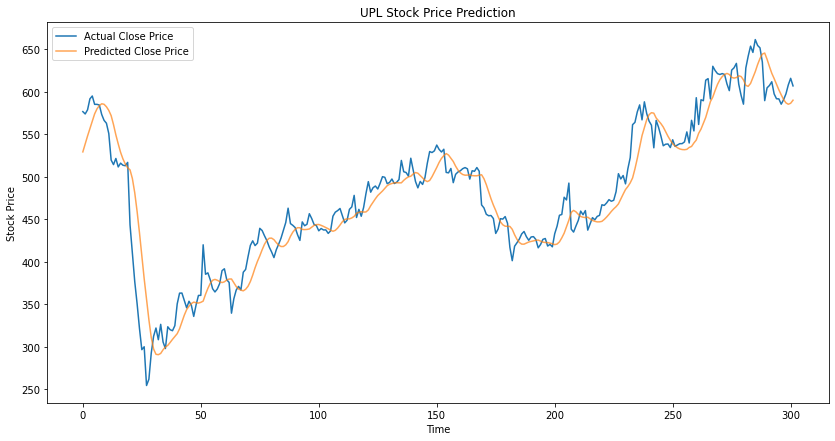

In [7]:
unique_stocks = df['Symbol'].unique()

# Initialize an empty list to store performance metrics for each stock
performance_list = []

for stock in unique_stocks:
    stock_df = df[df['Symbol'] == stock]
    if len(stock_df) > 2 * 60:  # Ensure there's enough data
        print(f"Processing {stock}...")
        trainScore_RMSE, trainScore_MSE, testScore_RMSE, testScore_MSE, predictions, y_test, true_values = train_model_for_stock(stock_df)
        plot_predictions(stock, true_values, predictions)
        
        # Create a dictionary with the performance metrics
        current_stock_performance = {
            'Stock': stock,  # Replace with the actual stock name
            'Train_RMSE': trainScore_RMSE,
            'Train_MSE': trainScore_MSE,
            'Test_RMSE': testScore_RMSE,
            'Test_MSE': testScore_MSE
        }
        
        # Append the dictionary to the list
        performance_list.append(current_stock_performance)

# Create a DataFrame from the list of dictionaries
performance_df = pd.DataFrame(performance_list)

# Now 'performance_df' contains the RMSE and MSE values for all stocks

In [8]:
performance_df

,Stock,Train_RMSE,Train_MSE,Test_RMSE,Test_MSE
0,UPL,0.030166,0.00091,0.033691,0.001135
